<a href="https://colab.research.google.com/github/Phantom-Ren/PR_TH/blob/master/Naive_Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# 模式识别·第三次作业·贝叶斯网络（Naive Bayesian）

#### 纪泽西 17375338

#### Last Modified:12nd,March,2020

</center>

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/Phantom-Ren/PR_TH/blob/master/Naive_Bayesian.ipynb"> 
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" /><br>Run in Google Colab</a></td>
</table>


## Part1: 导入库文件及数据集

#### 如需在其他环境运行需改变数据集所在路径

In [14]:
%tensorflow_version 2.x
import tensorflow as tf
import sklearn

import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import scipy.io as sio

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage.transform import pyramid_gaussian
from sklearn.model_selection import cross_val_score

path="/content/drive/My Drive/Pattern Recognition/Dataset"
os.chdir(path)
os.listdir(path)

['test_labels.mat', 'train_labels.mat', 'train_images.mat', 'test_images.mat']

## Part2:数据预处理

In [0]:
train_images=sio.loadmat("train_images.mat")
test_images=sio.loadmat("test_images.mat")
train_labels=sio.loadmat("train_labels.mat")
test_labels=sio.loadmat("test_labels.mat")

def trans(a):
  a1=a.swapaxes(0,2)
  a2=a1.swapaxes(1,2)
  return a2

train_dataset_np=np.array(train_images.pop('train_images'))
train_dataset_np=trans(train_dataset_np)
train_labels_np=np.array(train_labels.pop('train_labels1'))
train_labels_np=train_labels_np.reshape(60000)
test_dataset_np=np.array(test_images.pop('test_images'))
test_dataset_np=trans(test_dataset_np)
test_labels_np=np.array(test_labels.pop('test_labels1'))
test_labels_np=test_labels_np.reshape(10000)

### 显示预处理后数据集格式及例举数据

In [0]:
print(train_dataset_np.shape,train_dataset_np.size,train_dataset_np.ndim)
print(train_labels_np.shape,train_labels_np.size,train_labels_np.ndim)
print(test_dataset_np.shape,test_dataset_np.size,test_dataset_np.ndim)
print(test_labels_np.shape,test_labels_np.size,test_labels_np.ndim)

for i in range(0,2):
  plt.imshow(test_dataset_np[i,:,:])
  plt.xlabel(test_labels_np[i])
  plt.colorbar()
  plt.show()
  plt.imshow(train_dataset_np[i,:,:])
  plt.xlabel(train_labels_np[i])
  plt.colorbar()
  plt.show()



### 数据预处理
#### 1.二值化处理，目的是应用伯努利贝叶斯分类器：非零的灰度点置为1，将数据简化成对于某像素点是否为1，为0-1分布。<tr_d_pre,te_d_pre>
#### 2.不简化问题，将灰度值归一至[-1,1]区间<tr_pre,te_pre>

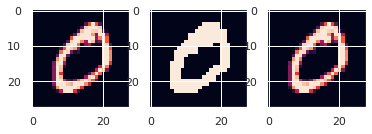

In [20]:
train_dataset_nb=train_dataset_np.reshape([60000,784])
test_dataset_nb=test_dataset_np.reshape([10000,784])

binarizer = sklearn.preprocessing.Binarizer().fit(train_dataset_nb)
tr_d_pre=binarizer.transform(train_dataset_nb)
te_d_pre=binarizer.transform(test_dataset_nb)

scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(train_dataset_nb)
tr_pre = scaling.transform(train_dataset_nb)
te_pre = scaling.transform(test_dataset_nb)


plt.subplot(1,3,1)
plt.imshow(train_dataset_nb[1,:].reshape([28,28]))
plt.subplot(1,3,2)
plt.imshow(tr_d_pre[1,:].reshape([28,28]))
plt.subplot(1,3,3)
plt.imshow(tr_pre[1,:].reshape([28,28]))
plt.show()

## Part3:模型建立


In [0]:
# 本函数用于可视化结果并展示分类准确性
def draw_confusionmatrix(ytest, yhat):
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(ytest, yhat)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    acc = accuracy_score(ytest, yhat)
    print(f"Sum Axis-1 as Classification accuracy: {acc}")


### 使用SKlearn快速建立模型

#### 1. 使用多项式贝叶斯分类器处理问题

Sum Axis-1 as Classification accuracy: 0.8365
Time Usage: 4.045991659164429


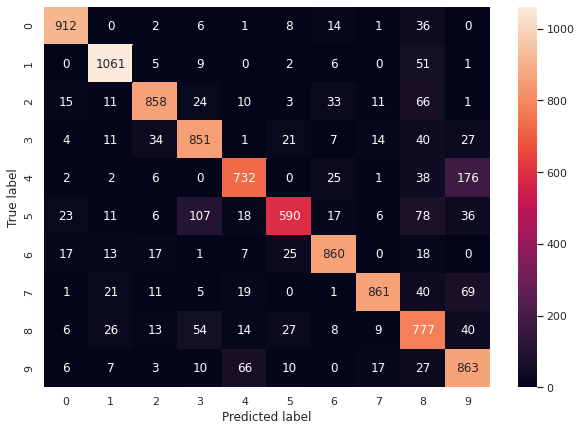

In [12]:
model = MultinomialNB()
from time import *
begin_time=time()
test_performance = model.fit(train_dataset_nb,train_labels_np)

yhat_1 = model.predict(test_dataset_nb)
draw_confusionmatrix(test_labels_np,yhat_1)

end_time=time()
final=end_time-begin_time
print('Time Usage:',final)

#### 2.使用伯努利贝叶斯分类器处理问题

Sum Axis-1 as Classification accuracy: 0.8413
Time Usage: 4.004442930221558


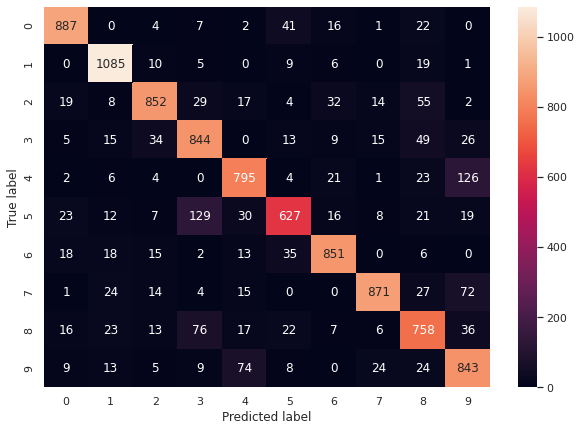

In [15]:
model1=BernoulliNB()
from time import *
begin_time=time()
test_performance = model1.fit(tr_d_pre,train_labels_np)

yhat_1 = model1.predict(te_d_pre)
draw_confusionmatrix(test_labels_np,yhat_1)

end_time=time()
final=end_time-begin_time
print('Time Usage:',final)

#### 3.索贝尔边缘化方法处理数据并应用多项式贝叶斯分类器

In [0]:
from scipy import ndimage
result = np.zeros_like(train_dataset_np)
result_test = np.zeros_like(test_dataset_np)
for i in range(train_dataset_np.shape[0]):
  result[i] = ndimage.sobel(train_dataset_np[i])

for i in range(test_dataset_np.shape[0]):
  result_test[i] = ndimage.sobel(test_dataset_np[i])

result_train = result.reshape(result.shape[0],784)
result_test = result_test.reshape(result_test.shape[0],784)

scaling1 = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train_dataset_nb)
result_train = scaling1.transform(result_train)
result_test = scaling1.transform(result_test)


Sum Axis-1 as Classification accuracy: 0.728
Time Usage: 0.4836561679840088 s


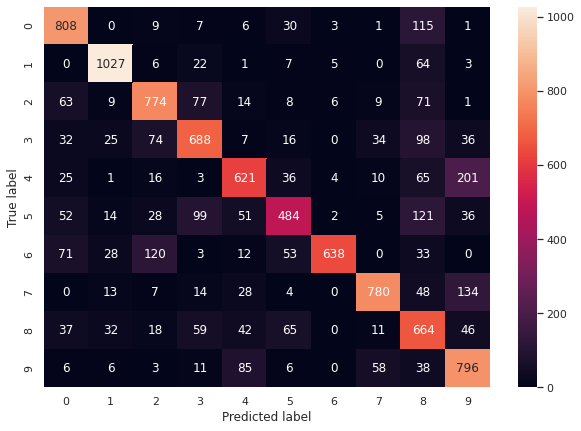

In [24]:
from time import *
begin_time=time()
test_performance = model.fit(result_train,train_labels_np)

yhat_2 = model.predict(result_test)
draw_confusionmatrix(test_labels_np,yhat_2)

end_time=time()
final=end_time-begin_time
print('Time Usage:',final,'s')

##### 从上图可见，索贝尔滤波因为多用于边缘检测中，故对手写数字识别效果并不好（因边缘过滤后，0与8，3与8，4与9，7与9更加相似）。故在手写数字识别方面不可取，

#### 4.不使用sklearn函数，独立建立函数应用最大后验概率朴素贝叶斯

In [31]:
# 计算条件概率P（A|Bi) <pabi> 和先验概率P(Bi) <pbi>
def CalProb(train_data,train_label): 
    num,dimsnum = train_data.shape
    labelnum = len(set(train_label)) 
 
    pbi = np.zeros(labelnum)
    pabi = np.zeros((labelnum,dimsnum))
    for i in range(num):
        label = train_label[i]
        pbi[label] = pbi[label] + 1 
        for j in range(dimsnum):
            pabi[label][j] = pabi[label][j] + train_data[i][j] 
    print('数据集中每类样本个数：',pbi)
    pabi = (pabi.T + 1) / (pbi + 2) 
    pbi = (pbi + 1) / (num + labelnum) 
    return  pbi, pabi 

def CalLogProb(a,pabi): ##计算对数条件概率 lob[P(A|Bi)]
    return a * np.log(pabi) + (1-a) * np.log(1-pabi)
                                                 
def test(test_data,test_label,pabi,pbi):  
    num,dimsnum = test_data.shape
    labelnum = len(set(test_label))
    acc = 0
    tested_cases = 0
    begin_time=time()
    for i in range(num):
        testdata = test_data[i]
        p_a_bi = np.log(pbi) ##第i个像素点属于A类的对数概率
        for j in range(labelnum): 
            for k in range(dimsnum):
                xk = testdata[k] 
                p_a_bi[j] = p_a_bi[j] + CalLogProb(xk,pabi[j][k])
        yhat = np.argmax(p_a_bi)
        acc = acc + (yhat == test_label[i])
        tested_cases = tested_cases + 1
        if tested_cases % 500 == 0:
          end_time=time()
          print('Test accuracy for the first %d batch is : %.3f . With Time Usage %.3f seconds '%(tested_cases/500,acc/tested_cases,end_time-begin_time))

pbi, pabi = CalProb(tr_d_pre,train_labels_np)
test(te_d_pre,test_labels_np,pabi.T,pbi)                                                  

数据集中每类样本个数： [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
Test accuracy for the first 1 batch is : 0.828 . With Time Usage 43.466 seconds 
Test accuracy for the first 2 batch is : 0.817 . With Time Usage 87.810 seconds 
Test accuracy for the first 3 batch is : 0.793 . With Time Usage 131.670 seconds 
Test accuracy for the first 4 batch is : 0.794 . With Time Usage 175.297 seconds 
Test accuracy for the first 5 batch is : 0.796 . With Time Usage 218.934 seconds 
Test accuracy for the first 6 batch is : 0.801 . With Time Usage 262.466 seconds 
Test accuracy for the first 7 batch is : 0.802 . With Time Usage 306.409 seconds 
Test accuracy for the first 8 batch is : 0.800 . With Time Usage 350.443 seconds 
Test accuracy for the first 9 batch is : 0.798 . With Time Usage 394.209 seconds 
Test accuracy for the first 10 batch is : 0.800 . With Time Usage 438.015 seconds 
Test accuracy for the first 11 batch is : 0.812 . With Time Usage 481.186 seconds 
Test accuracy for the fi

##### 由于自定义函数未考虑并行运算关系，运行速度较慢。
##### 最终准确性为：0.841 ，可见最大后验概率贝叶斯分布大致能正确分类。

#### 5.LENET-5 Bayes Convolutional Netrual Network

In [0]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

model0 = tf.keras.Sequential()

model0.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
model0.add(MaxPooling2D(pool_size=(2, 2)))
model0.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))
model0.add(Flatten())
model0.add(Dense(120, activation='relu'))
model0.add(Dense(84, activation='relu'))
model0.add(Dense(10, activation='softmax'))

model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)               

In [0]:
model0.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train / 255
x_test = x_test / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

model0.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test, y_test))
score = model0.evaluate(x_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

11493376/11490434 [==============================] - 0s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 23s 376us/sample - loss: 0.3344 - accuracy: 0.9036 - val_loss: 0.0846 - val_accuracy: 0.9730
Epoch 2/20
60000/60000 [==============================] - 22s 363us/sample - loss: 0.0892 - accuracy: 0.9729 - val_loss: 0.0606 - val_accuracy: 0.9811
Epoch 3/20
60000/60000 [==============================] - 22s 366us/sample - loss: 0.0635 - accuracy: 0.9806 - val_loss: 0.0439 - val_accuracy: 0.9857
Epoch 4/20
60000/60000 [==============================] - 22s 364us/sample - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.0400 - val_accuracy: 0.9873
Epoch 5/20
60000/60000 [==============================] - 22s 365us/sample - loss: 0.0426 - accuracy: 0.9868 - val_loss: 0.0353 - val_accuracy: 0.9885
Epoch 6/20
60000/60000 [==============================] - 22s 366us/sample - loss: 0.0370 - accuracy: 0.9883 - val_loss: 0.0440 - 